Fit a gaussian mixture model to a dataset of i.i.d. samples.

http://www.ics.uci.edu/~smyth/courses/cs274/notes/EMnotes.pdf

The distribution is supposed to be the mixture of $K$ gaussians in $\mathbb{R}^d$.

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import matplotlib.colors as colors

In [119]:
d = 2
K = 3
N = 200

mus = [10*rnd.rand(d) for k in range(K)]

def random_covariance_matrix(d):
    A = rnd.randn(d,d)
    return np.dot(A,A.transpose()) + abs(rnd.rand())*np.eye(d)

sigmas = [random_covariance_matrix(d) for k in range(K)]
#sigmas = [np.array([[1,0],[0,1]]) for _ in range(K)]
ds,vs = [],[]
for k in range(K):
    lbd,v = np.linalg.eig(sigmas[k])
    ds.append(lbd); vs.append(v)

pis = [rnd.random() for _ in range(K)]
pis = [pis[k]/np.sum(pis) for k in range(K)]

In [120]:
def plot_gaussian(mu,sigma,alpha_max):
    lbd,v = np.linalg.eig(sigma)
    lbd = np.sqrt(lbd)
    std_dev = np.sqrt(lbd)
    aa = np.linspace(-4,4,100)
    aa,bb = np.meshgrid(aa,aa)
    xx = aa*lbd[0]*v[0,0] + bb*lbd[1]*v[0,1] + mu[0]
    yy = aa*lbd[0]*v[1,0] + bb*lbd[1]*v[1,1] + mu[1]
    zz = 1/np.sqrt(2*np.pi)*np.exp(-(aa**2+bb**2)/2)
    
    
    line, = plt.plot([],[])
    color = line.get_color()
    transparent = colors.to_rgba(color)[:3] + (0,)
    translucent = transparent[:3] + (1,)
    cmap = colors.LinearSegmentedColormap.from_list('unnamed_cmap',[transparent,translucent])
    plt.pcolor(xx,yy,zz,cmap=cmap,snap=False,antialiaseds=True)
    #v = [1/np.sqrt(2*np.pi)*np.exp(-k*k/2) for k in [-2,-1,-0.5]]
    plt.contour(xx,yy,zz,2,colors=color)

In [121]:
xx = []
for _ in range(N):
    p = rnd.random()
    k = 0
    while p>pis[k]:
        p -= pis[k]; k+=1
    # Gaussian from mus[k], sigmas[k]
    a,b = rnd.randn(2)
    x = mus[k][:] + a*np.sqrt(ds[k][0])*vs[k][:,0] + b*np.sqrt(ds[k][1])*vs[k][:,1]
    xx.append(x)
xx = np.array(xx)

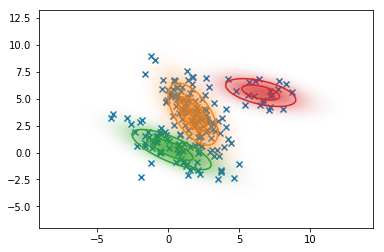

In [122]:
plt.scatter(xx[:,0],xx[:,1],marker='x')
plt.plot([],[])
for k in range(K):
    plot_gaussian(mus[k],sigmas[k],pis[k])
plt.show()

In [123]:
def gaussian_proba(x,mu,sigma):
    sigma_d,sigma_v = np.linalg.eig(sigma)
    y = (sigma_v.transpose().dot(x-mu))/np.sqrt(sigma_d)
    return 1/(2*np.pi)**(d/2) * 1/np.sqrt(np.prod(sigma_d)) * np.exp(-0.5*np.dot(y,y))

## Actual EM algorithm

Initialize $\Theta = (\mu,\Sigma,\pi)$ to arbitrary values.

In [124]:
mu_est = [20*rnd.rand(d) for k in range(K)]
sigma_est = [random_covariance_matrix(d) for k in range(K)]
pi_est = np.ones(K)/K

### E step
Compute $w_{i,k}$:
$$w_{i,k} = \frac{\pi_k p_k(x_i \mid z_k,\theta_k)}{\sum_j \pi_j p_j(x_i \mid z_j,\theta_j)}$$

In [125]:
w = np.zeros((N,K))
for i in range(N):
    for k in range(K):
        w[i,k] = pi_est[k] * gaussian_proba(xx[i,:],mu_est[k],sigma_est[k])
w = w / np.sum(w,1)[:,None]

### M step
Compute the weights, means and covariance matrices, according to the new data.

In [126]:
N_k = np.sum(w,0)
print(N_k)

[  1.99888209e+02   1.11791187e-01   3.69710773e-60]


In [127]:
pi_est = N_k / N
print(pi_est)

[  9.99441044e-01   5.58955933e-04   1.84855387e-62]


In [128]:
for k in range(K):
    mu_est[k] = 1/N_k[k] * np.sum(w[:,k,None]*xx[:,:],axis=0)
print(mu_est)

[array([ 1.77341141,  2.92070178]), array([ 8.68821044,  5.78650643]), array([ 7.84373854,  6.6659615 ])]


In [129]:
for k in range(K):
    sigma_est[k] = np.zeros((d,d))
    for i in range(N):
        y = xx[i,:] - mu_est[k][:]
        sigma_est[k] += w[i,k] * np.outer(y,y)
    sigma_est[k] /= N_k[k]
print(sigma_est)

[array([[ 5.46748254,  0.90909292],
       [ 0.90909292,  6.28473271]]), array([[ 0.03362225, -0.04490839],
       [-0.04490839,  0.07996495]]), array([[ 0.00369576, -0.00134792],
       [-0.00134792,  0.00068463]])]


### Computing the error
Convergence is generally detected by computing the value of the log-likelihood after each iteration .

In [130]:
logl = 0
for i in range(N):
    proba = 0
    for k in range(K):
        proba += pi_est[k] * gaussian_proba(xx[i,:],mu_est[k],sigma_est[k])
    logl += np.log(proba)
print(logl)

-916.012358384


### Let's wrap this up

In [133]:
mu_est = [20*rnd.rand(d) for k in range(K)]
sigma_est = [random_covariance_matrix(d) for k in range(K)]
pi_est = np.ones(K)/K

logl_prev = -1e100
for it in range(100):
    w = np.zeros((N,K))
    for i in range(N):
        for k in range(K):
            w[i,k] = pi_est[k] * gaussian_proba(xx[i,:],mu_est[k],sigma_est[k])
    w = w / np.sum(w,1)[:,None]
    N_k = np.sum(w,0)
    pi_est = N_k / N
    print('pi =',pi_est)
    for k in range(K):
        mu_est[k] = 1/N_k[k] * np.sum(w[:,k,None]*xx[:,:],axis=0)
    print('mu =',mu_est)
    for k in range(K):
        sigma_est[k] = np.zeros((d,d))
        for i in range(N):
            y = xx[i,:] - mu_est[k][:]
            sigma_est[k] += w[i,k] * np.outer(y,y)
        sigma_est[k] /= N_k[k]
    print('sigma =',sigma_est)
    
    logl = 0
    for i in range(N):
        proba = 0
        for k in range(K):
            proba += pi_est[k] * gaussian_proba(xx[i,:],mu_est[k],sigma_est[k])
        logl += np.log(proba)
    print('logl =',logl)
    if logl < logl_prev + 1e-5:
        print('Converged after %d iterations' % it)
        break
    else:
        logl_prev = logl

pi = [ 0.87764176  0.0916486   0.03070964]
mu = [array([ 1.7759028 ,  2.52020181]), array([-0.25336893,  5.90869999]), array([ 7.87671006,  5.50137407])]
sigma = [array([[ 4.24043915,  0.99278194],
       [ 0.99278194,  5.54572252]]), array([[ 2.60069226,  1.26310512],
       [ 1.26310512,  2.51795772]]), array([[ 0.35201361,  0.15542188],
       [ 0.15542188,  0.79398923]])]
logl = -902.6632451
pi = [ 0.8616264   0.08923087  0.04914273]
mu = [array([ 1.63232123,  2.47825711]), array([-0.03140189,  5.87717167]), array([ 7.60290298,  5.34253468])]
sigma = [array([[ 3.82459207,  0.65990586],
       [ 0.65990586,  5.57133704]]), array([[ 2.22629142,  0.76617171],
       [ 0.76617171,  2.37870008]]), array([[ 0.39321651,  0.22823609],
       [ 0.22823609,  0.73955583]])]
logl = -895.694530693
pi = [ 0.85026669  0.08797444  0.06175887]
mu = [array([ 1.53033116,  2.44871672]), array([ 0.19130922,  5.88448513]), array([ 7.43628487,  5.22284657])]
sigma = [array([[ 3.58741565,  0.45380443],
  

mu = [array([ 1.11421851,  1.71825366]), array([ 1.43038422,  4.45930082]), array([ 6.80745601,  5.43118891])]
sigma = [array([[ 3.60542291, -0.26340596],
       [-0.26340596,  5.18066352]]), array([[ 1.34762062, -1.59540214],
       [-1.59540214,  2.9688535 ]]), array([[ 1.1468649 , -0.07753502],
       [-0.07753502,  0.84748233]])]
logl = -868.368095846
pi = [ 0.58978457  0.31024415  0.09997128]
mu = [array([ 1.10547934,  1.68560706]), array([ 1.43638135,  4.46396228]), array([ 6.79848155,  5.43396488])]
sigma = [array([[ 3.61904638, -0.28559709],
       [-0.28559709,  5.09161036]]), array([[ 1.34588605, -1.58319526],
       [-1.58319526,  2.99089898]]), array([[ 1.16423192, -0.08500553],
       [-0.08500553,  0.84963598]])]
logl = -868.190736551
pi = [ 0.58285007  0.31670127  0.10044866]
mu = [array([ 1.09592581,  1.64712158]), array([ 1.44194632,  4.47144958]), array([ 6.78804286,  5.43725474])]
sigma = [array([[ 3.63483037, -0.31290932],
       [-0.31290932,  4.98168277]]), array(

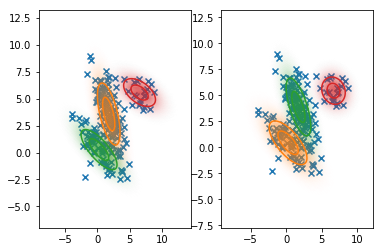

In [134]:
# Compare the ground truth with the result

plt.subplot(1,2,1)
plt.scatter(xx[:,0],xx[:,1],marker='x')
plt.plot([],[])
for k in range(K):
    plot_gaussian(mus[k],sigmas[k],pis[k])

plt.subplot(1,2,2)
plt.scatter(xx[:,0],xx[:,1],marker='x')
plt.plot([],[])
#for k in range(K):
    #plot_gaussian(mus[k],sigmas[k],pis[k])
for k in range(K):
    plot_gaussian(mu_est[k],sigma_est[k],pi_est[k])


plt.show()
